# Code Overview
We'll try and explain what we can here...

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np
import json
import pickle
from prediction_pipeline.model_shap_explainer import build_explainer

#plt.style.use('https://pltstyle.s3.eu-west-1.amazonaws.com/zinc.mplstyle')
plt.style.use('https://pltstyle.s3.eu-west-1.amazonaws.com/light-gray.mplstyle')

plt.rcParams["font.family"] = "DM Mono"

# Player Weights
The method to determine player rankings goes through a series of training steps, ultimately using a `ridge regression` model. For every position, we evaluated the different stats that makes up each position (rushing, passing, tackles, snap counts, etc.). If we can break down how much each stat influenced the final decision on weighting, that was then used to rank each player, per game.



In [2]:
# Define our positions
positions = {'DB', 'DL', 'K', 'LB', 'OL', 'P', 'QB', 'RB', 'TE', 'WR'}

In [3]:
def model_loader(file_loc: str) -> pickle:
    with open(file_loc, 'rb') as f:
        return pickle.load(f)

In [4]:
qb_stats_train = pd.read_csv('data/intermediate/model_ridge__position_QB__x_train.csv')
qb_stats_test = pd.read_csv('data/intermediate/model_ridge__position_QB__x_test.csv')
qb_stats_model = model_loader('data/intermediate/model_ridge__position_QB__model.pkl')

In [5]:
explainer = shap.LinearExplainer(qb_stats_model, qb_stats_train)
shap_values = explainer(qb_stats_train)
print(f'Shape of our data: {qb_stats_test.shape}')

Shape of our data: (29, 73)


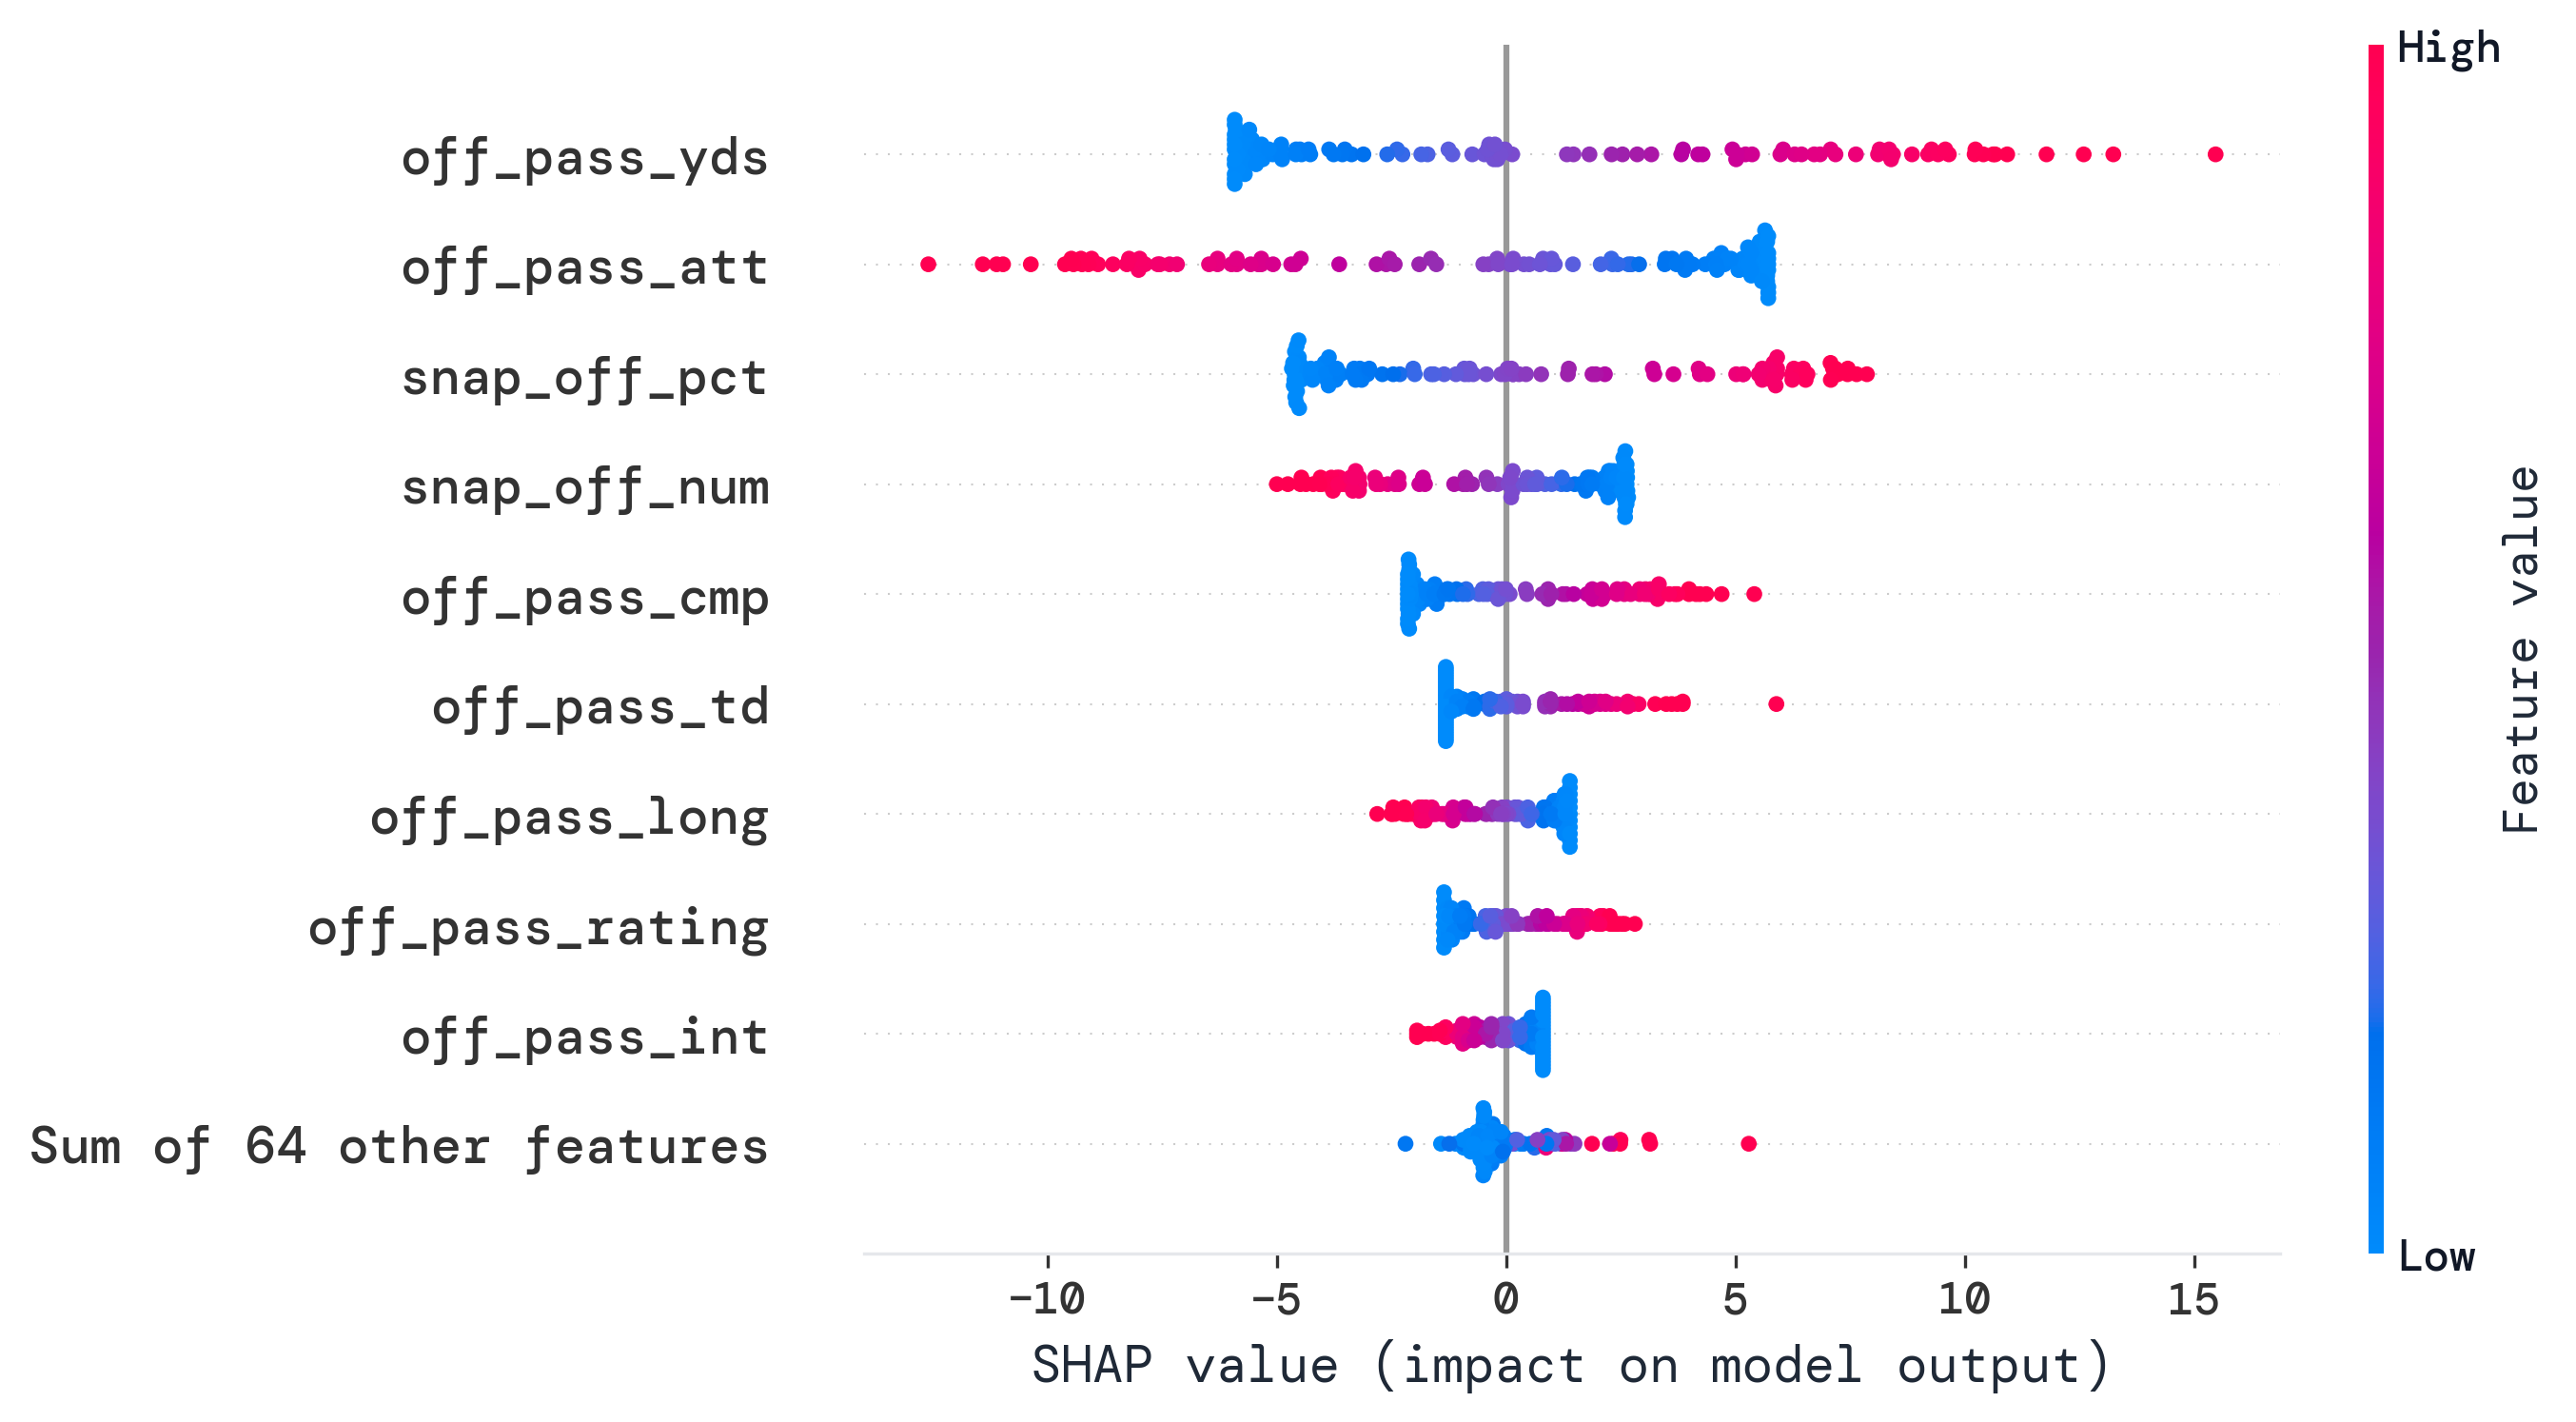

In [6]:
# Overall impact on the final values
shap.plots.beeswarm(shap_values)

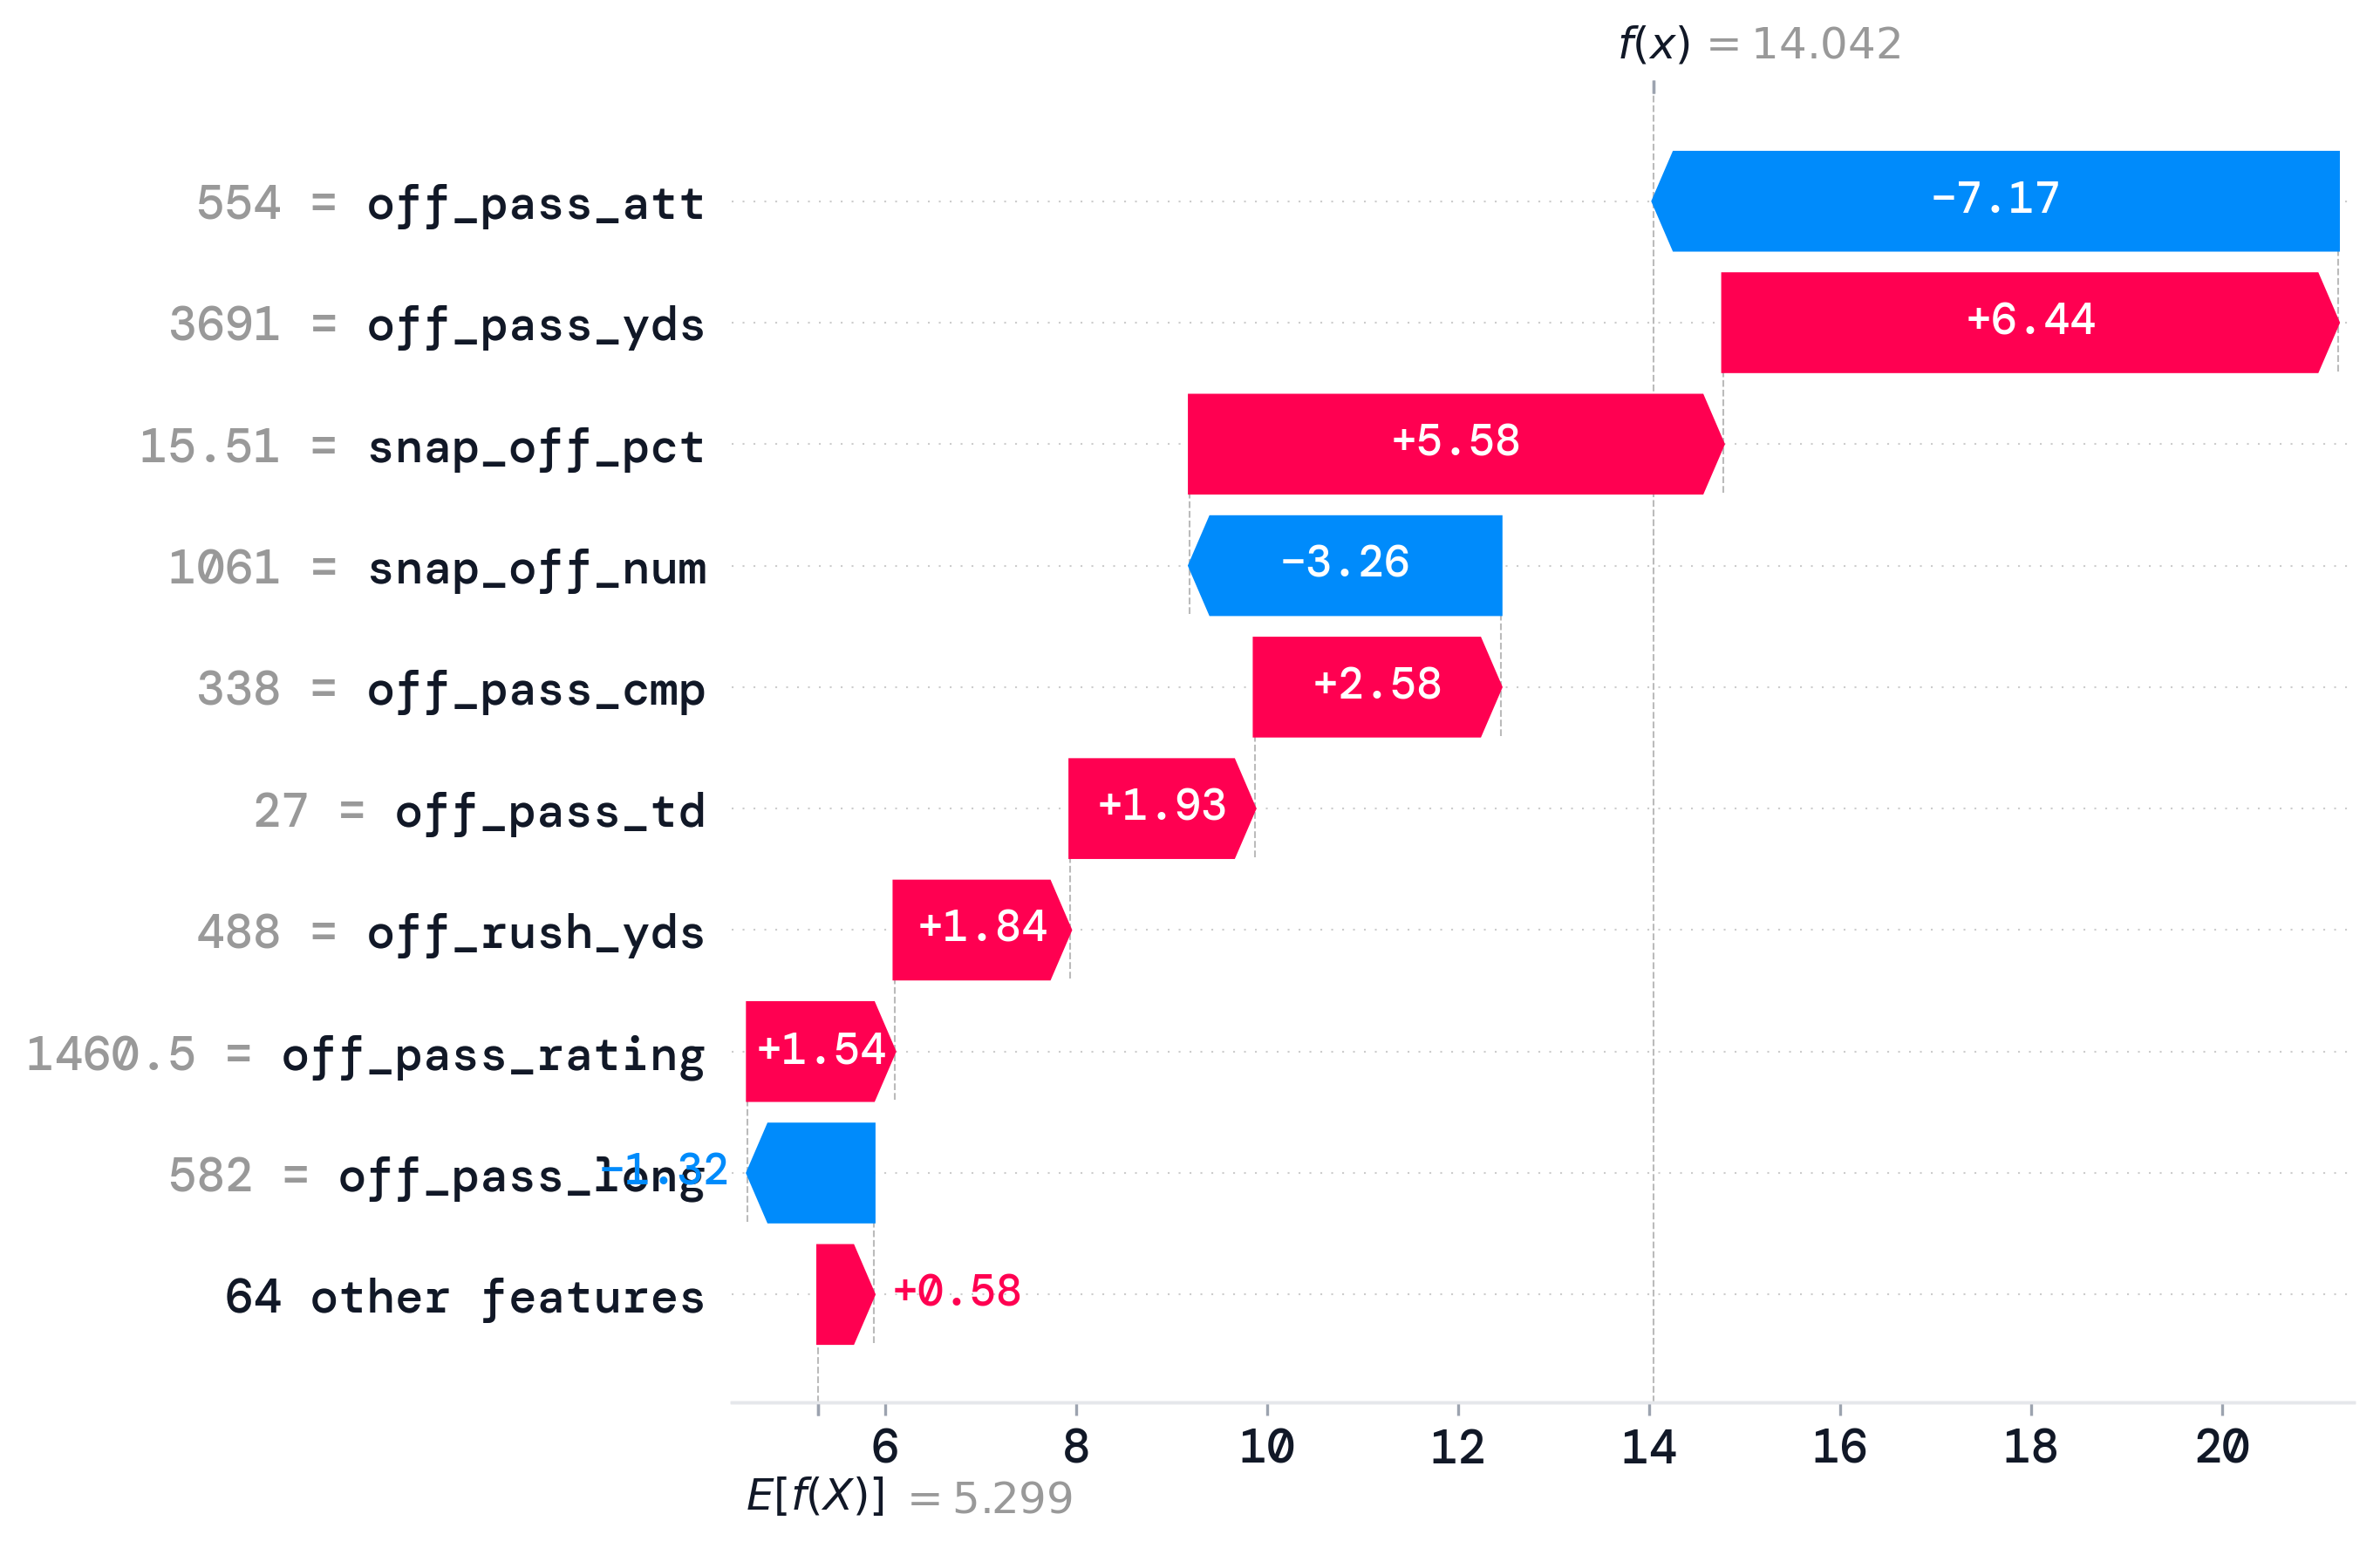

In [7]:
# This gives us information about the 42nd row in our training set:
shap.plots.waterfall(shap_values[42])

## SHAP Review
SHAP tells us for a single data point, in this instance, in the training set, how impactful is each feature towards the over final weight.

For a quarterback, it makes sense - it's offensive passing yards and offensive passing attempts, while it's not necessary to show each of these, we'll take a look at the top 2 features for every position.

In [8]:
def shap_plot_by_position(position: str) -> None:
    """Loads the stats model associated with the position and saves it to
    data/output/plots/
    """
    plt.figure(figsize=(10,5))
    pos_model = model_loader(f'data/intermediate/model_ridge__position_{position}__model.pkl')
    pos_train = pd.read_csv(f'data/intermediate/model_ridge__position_{position}__x_train.csv')

    explainer = shap.LinearExplainer(pos_model, pos_train)
    shap_values = explainer(pos_train)

    # Call beeswarm to plot it
    fig = shap.plots.beeswarm(shap_values, show=False)
    plt.title(f'SHAP Top Features for {position}')
    plt.tight_layout()
    plt.savefig(f'data/output/plots/shap_summary_{position}_stats.png')
    plt.clf()

    return None

    
# Loop through each position and store the plot
#for p in positions:
    #shap_plot_by_position(p)

### Summary of the Different Position SHAP Plots
Looking at the different plots, we have the following

1. QB - offensive passing yards, offensive passing attempts
2. DB - game status home, snap counts start percent
3. DL - game status home, snap counts start percent
4. K - kick scoring fgm, kick scoring xpm
5. LB - Snap defense number, snap defense percent
6. OL - Snap offense number, snap count start percent
7. P - Kick punt yards, kick punt
8. RB - Offensive rushing yards, snap offensive number
9. TE - Offensive receiving yards, snap offensive percent
10. WR - Offensive receiving yards, offensive receive target

# Evaluating the Model

In [9]:
# Model loads for the supervised regression
with open('data/model/single_target_random_forest_model.pkl', 'rb') as f:
    model_rfr = pickle.load(f)


In [10]:
# Specify our regression training and test set for SHAP
roof_dict = {
   'outdoors': 1,
   'dome': 2,
   'retractable roof (closed)': 3,
   'retractable roof (open)': 4
}
reg_x_train = pd.read_csv('data/intermediate/model_rfr__x_train.csv')
reg_x_test = pd.read_csv('data/intermediate/model_rfr__x_test.csv')
reg_x_train['roof_type'] = reg_x_train['roof_type'].map(roof_dict.get)

try:
    reg_x_test.drop(columns=['Unnamed: 0'], inplace=True)
except KeyError:
    print(f'{reg_x_test.shape[1]} columns in test set. No "Unnamed: 0" column')
except Exception as e:
    print(f'Some other error: {e}')
    pass

16 columns in test set. No "Unnamed: 0" column


In [11]:
# Random Forest Explainer
rfr_explainer = shap.Explainer(model_rfr.best_estimator_['regressor'])
#rfr_shap_values = rfr_explainer.shap_values(reg_x_train)
#TODO: GET Multi-Output Regressor to correctly work

In [ ]:
#shap_vals = rfr_explainer.shap_values(reg_x_train.sample(250))

In [13]:
rfr_results = pd.read_csv('data/output/random_forest_model_output.csv')

In [14]:
# Adding in some evaluation metrics
def game_outcome(team_a_score: float, team_b_score: float) -> str:
    """Compares the home team's score against the opponents
    Returns either a 'w' or a 'l'
    """
    if team_a_score > team_b_score:
        return "w"
    elif team_b_score > team_a_score:
        return "l"
    else:
        return "t"
    
def calc_game_mape(game_residual: float, score_actual: float) -> float:
    if score_actual == 0:
        score_actual = 1e-10
    
    return game_residual/score_actual
    

rfr_results['home_results_actual'] = rfr_results[['score_home_test', 'score_opp_test']].apply(lambda row: game_outcome(row['score_home_test'], row['score_opp_test']), axis=1)
rfr_results['opp_results_actual'] = rfr_results[['score_opp_test', 'score_home_test']].apply(lambda row: game_outcome(row['score_opp_test'], row['score_home_test']), axis=1)
rfr_results['home_results_pred'] = rfr_results[['score_home_pred', 'score_opp_pred']].apply(lambda row: game_outcome(row['score_home_pred'], row['score_opp_pred']), axis=1)
rfr_results['opp_results_pred'] = rfr_results[['score_opp_pred', 'score_home_pred']].apply(lambda row: game_outcome(row['score_opp_pred'], row['score_home_pred']), axis=1)

rfr_results['spread_actual'] = rfr_results['score_home_test'] - rfr_results['score_opp_test']
rfr_results['spread_pred'] = rfr_results['score_home_pred'] - rfr_results['score_opp_pred']
rfr_results['home__abs_residual'] = abs(rfr_results['score_home_test'] - rfr_results['score_home_pred'])
rfr_results['opp__abs_residual'] = abs(rfr_results['score_opp_test'] - rfr_results['score_opp_pred'])


# Handle 0 for the score:
rfr_results['home__game_mape'] = rfr_results[['home__abs_residual', 'score_home_test']].apply(lambda x: calc_game_mape(x['home__abs_residual'], x['score_home_test']), axis=1)
rfr_results['opp__game_mape'] = rfr_results[['opp__abs_residual', 'score_opp_test']].apply(lambda x: calc_game_mape(x['opp__abs_residual'], x['score_opp_test']), axis=1)


rfr_results['per_game_mape'] = (rfr_results['home__game_mape'] + rfr_results['opp__game_mape'])/2
rfr_results['home__correct_pred'] = (rfr_results['home_results_actual'] == rfr_results['home_results_pred']).astype(int)
rfr_results['opp__correct_pred'] = (rfr_results['opp_results_actual'] == rfr_results['opp_results_pred']).astype(int)

rfr_results.head()

,Unnamed: 0,game_id,boxscore_stub,week_ind,day_int,attendance,roof_type,humidity_pct,wind_speed,temperature,...,opp_results_pred,spread_actual,spread_pred,home__abs_residual,opp__abs_residual,home__game_mape,opp__game_mape,per_game_mape,home__correct_pred,opp__correct_pred
0,2044,buf_rai_2023-09-17,/boxscores/202309170buf.htm,2.0,2,70772.0,outdoors,57.0,4.0,70.0,...,l,28.0,8.576455,8.365681,11.057864,0.220150,1.105786,0.662968,1,1
1,2045,was_buf_2023-09-24,/boxscores/202309240was.htm,3.0,2,64291.0,outdoors,96.0,1.0,65.0,...,w,-34.0,-0.732863,18.127970,15.139167,6.042657,0.409167,3.225912,1,1
2,2046,buf_mia_2023-10-01,/boxscores/202310010buf.htm,4.0,2,70881.0,outdoors,71.0,2.0,70.0,...,l,28.0,2.160511,23.475757,2.363732,0.489078,0.118187,0.303632,1,1
3,2047,buf_jax_2023-10-08,/boxscores/202310080buf.htm,5.0,2,61273.0,outdoors,52.0,7.0,75.0,...,l,-5.0,1.837388,7.016240,0.178852,0.350812,0.007154,0.178983,0,0
4,2048,buf_nyg_2023-10-15,/boxscores/202310150buf.htm,6.0,2,70515.0,outdoors,90.0,7.0,46.0,...,l,5.0,16.504246,18.720930,7.216684,1.337209,0.801854,1.069532,1,1


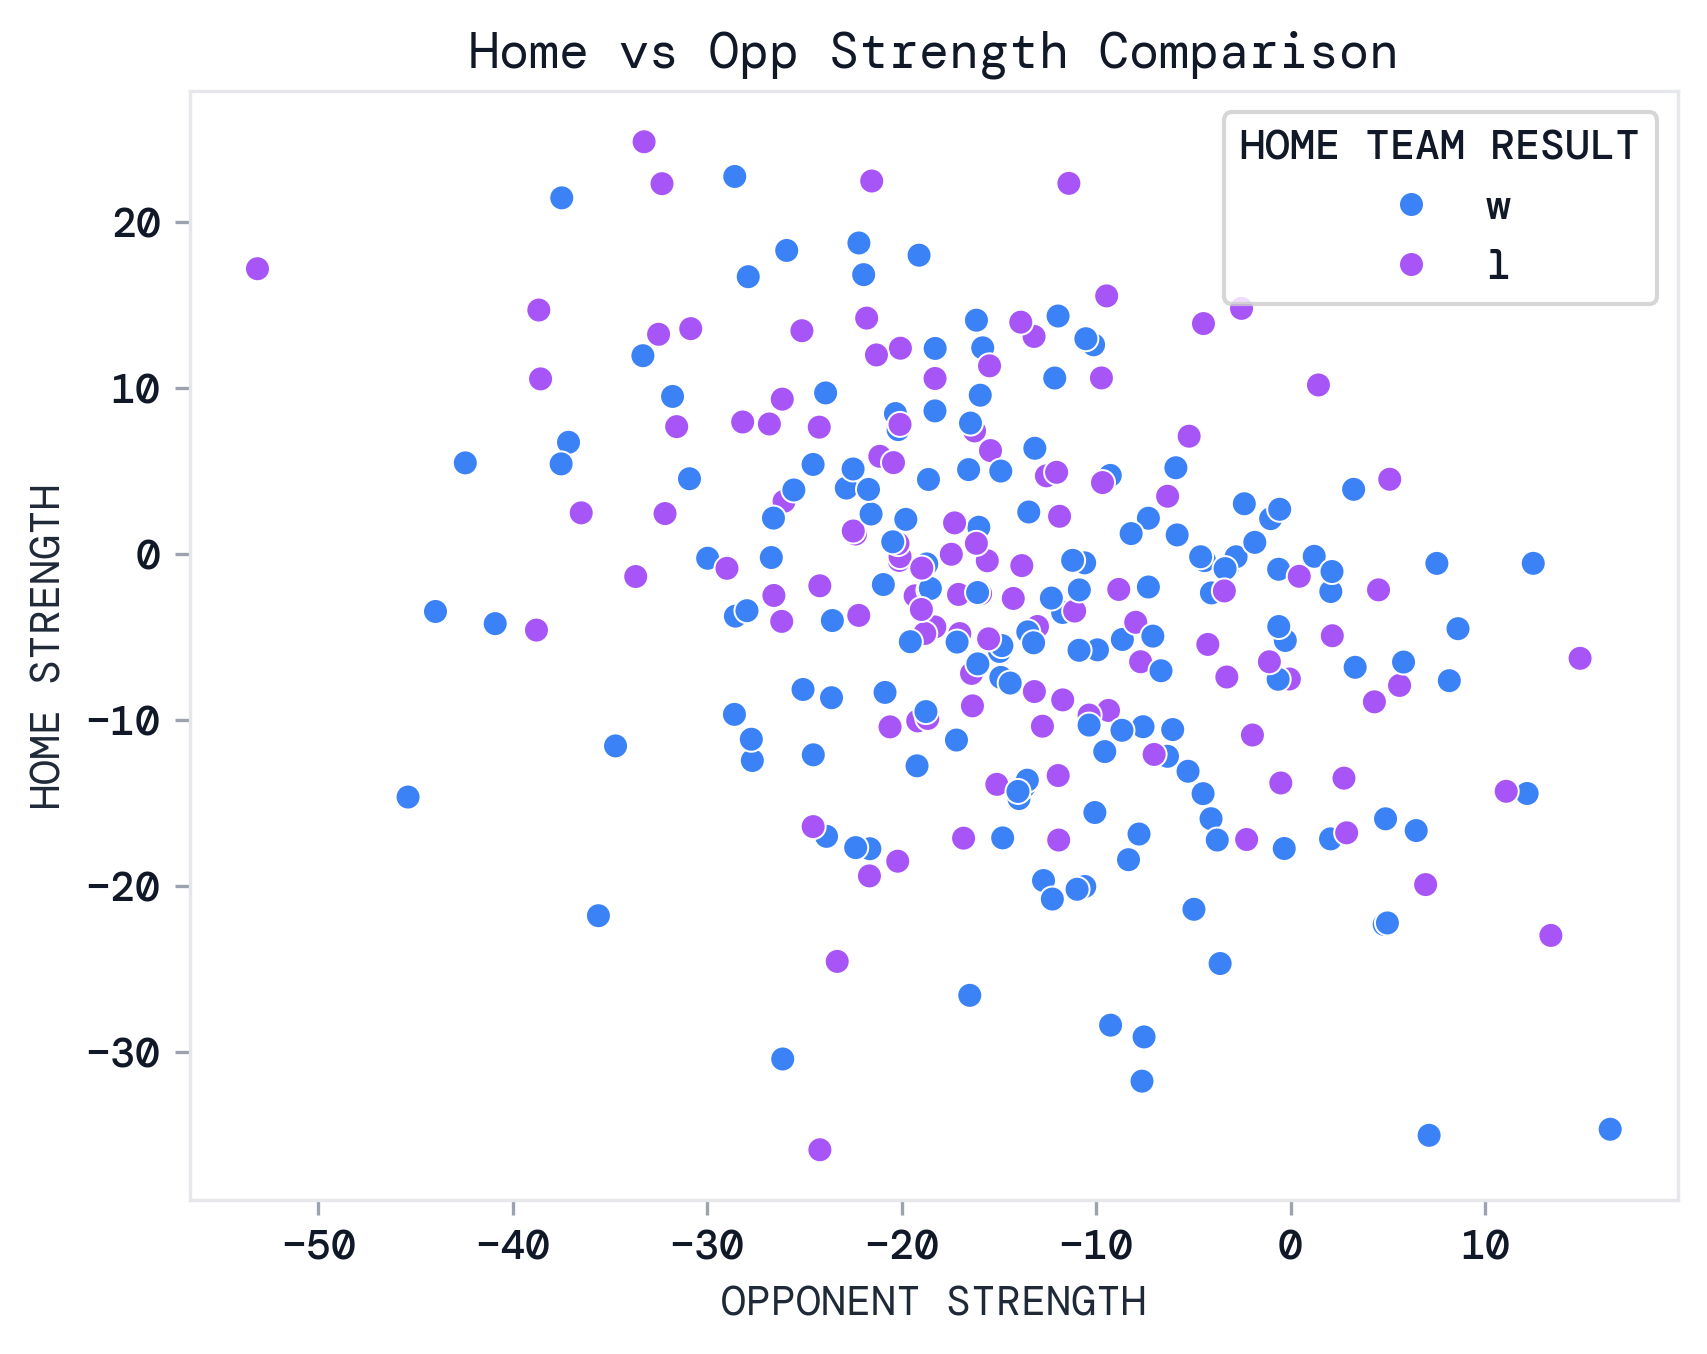

<Figure size 2100x1200 with 0 Axes>

In [16]:
#sns.set_theme(style)
sns.scatterplot(data=rfr_results, x='home_strength', y = 'opp_strength', hue='home_results_actual')
plt.title('Home vs Opp Strength Comparison')
plt.xlabel('OPPONENT STRENGTH')
plt.ylabel('HOME STRENGTH')
plt.legend(title='HOME TEAM RESULT')
plt.figure(figsize=[7,4])

plt.show()

Text(0, 0.5, 'Score of Home Team')

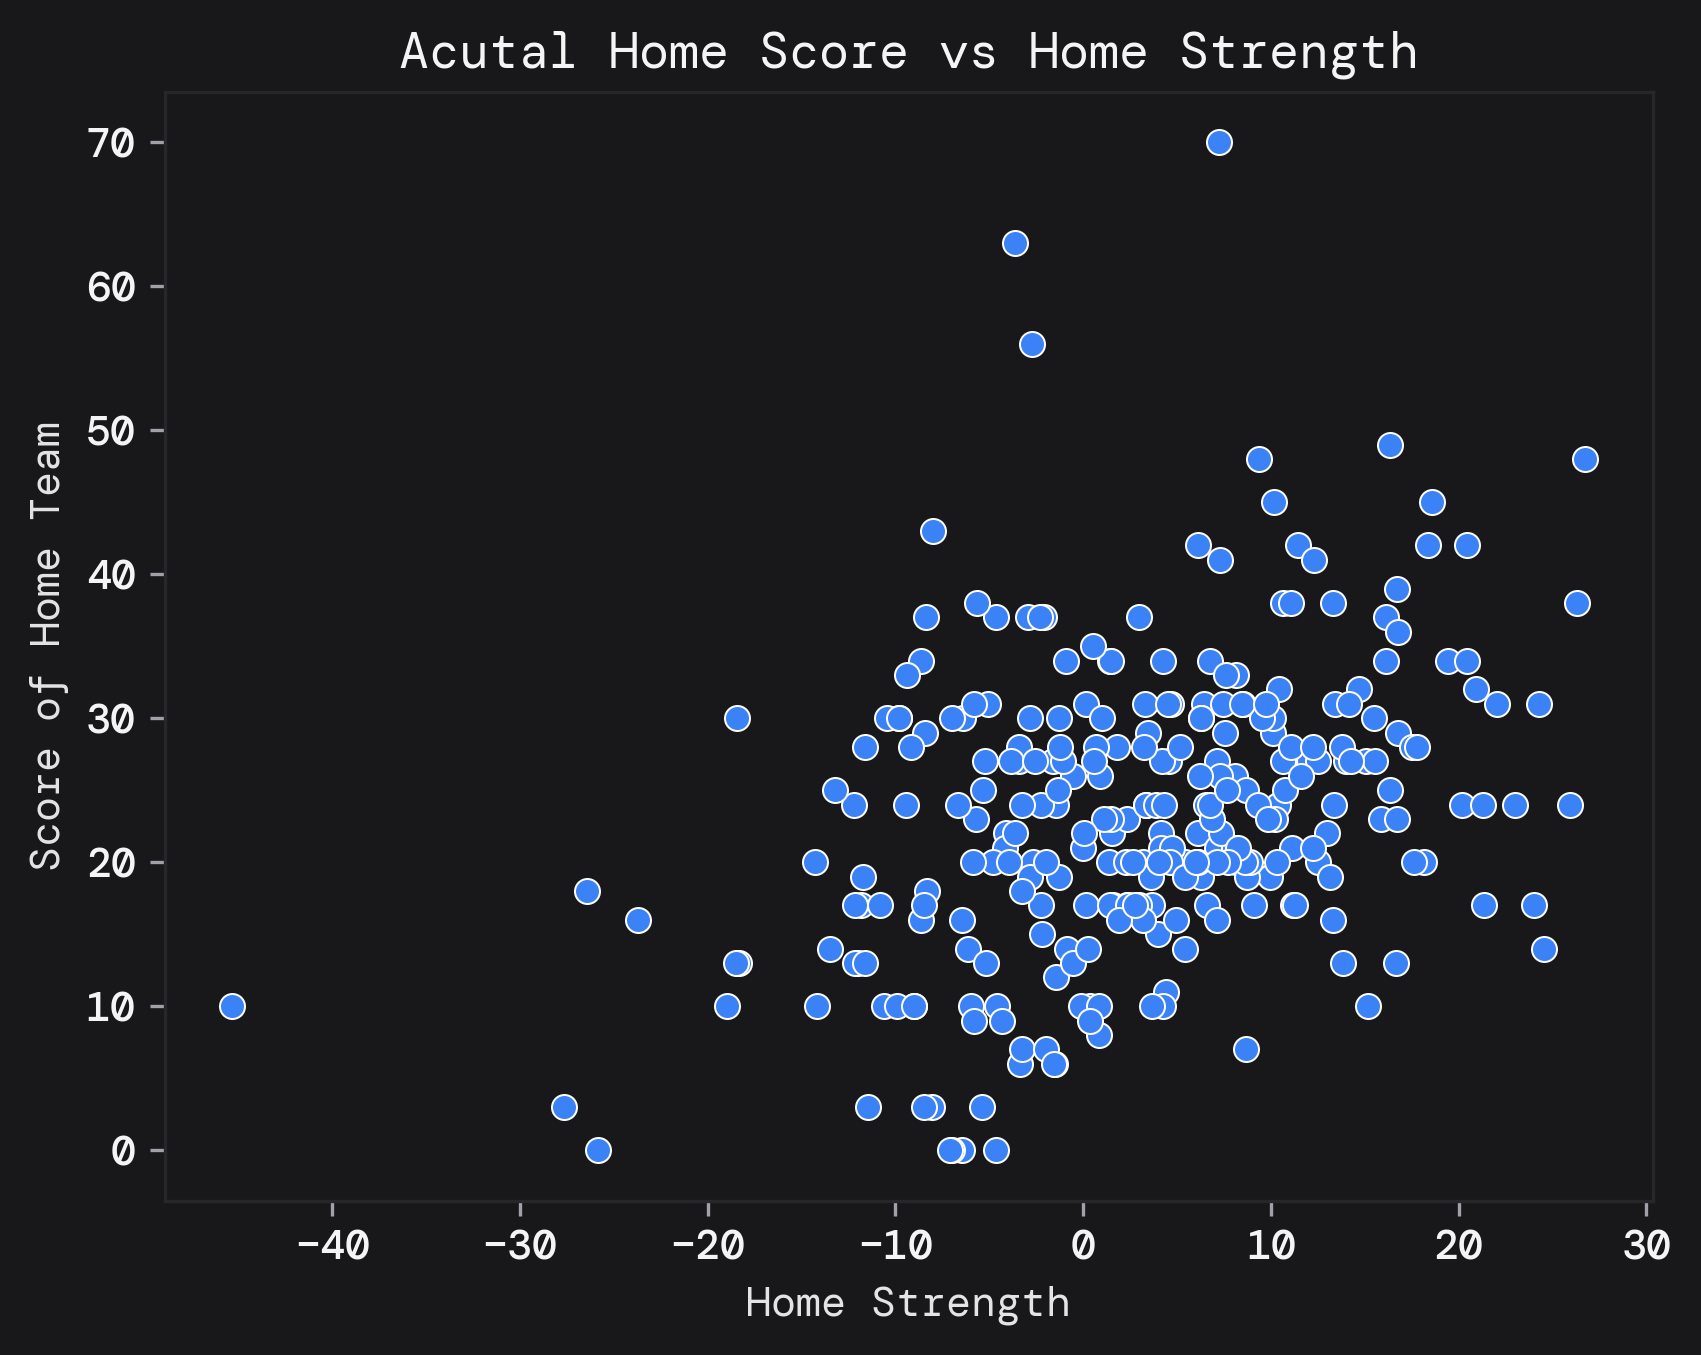

In [71]:
# Relationship with Score vs Home Stength
sns.scatterplot(data=rfr_results, y='score_home_test', x = 'home_strength')
plt.title("Acutal Home Score vs Home Strength")
plt.xlabel("Home Strength")
plt.ylabel("Score of Home Team")

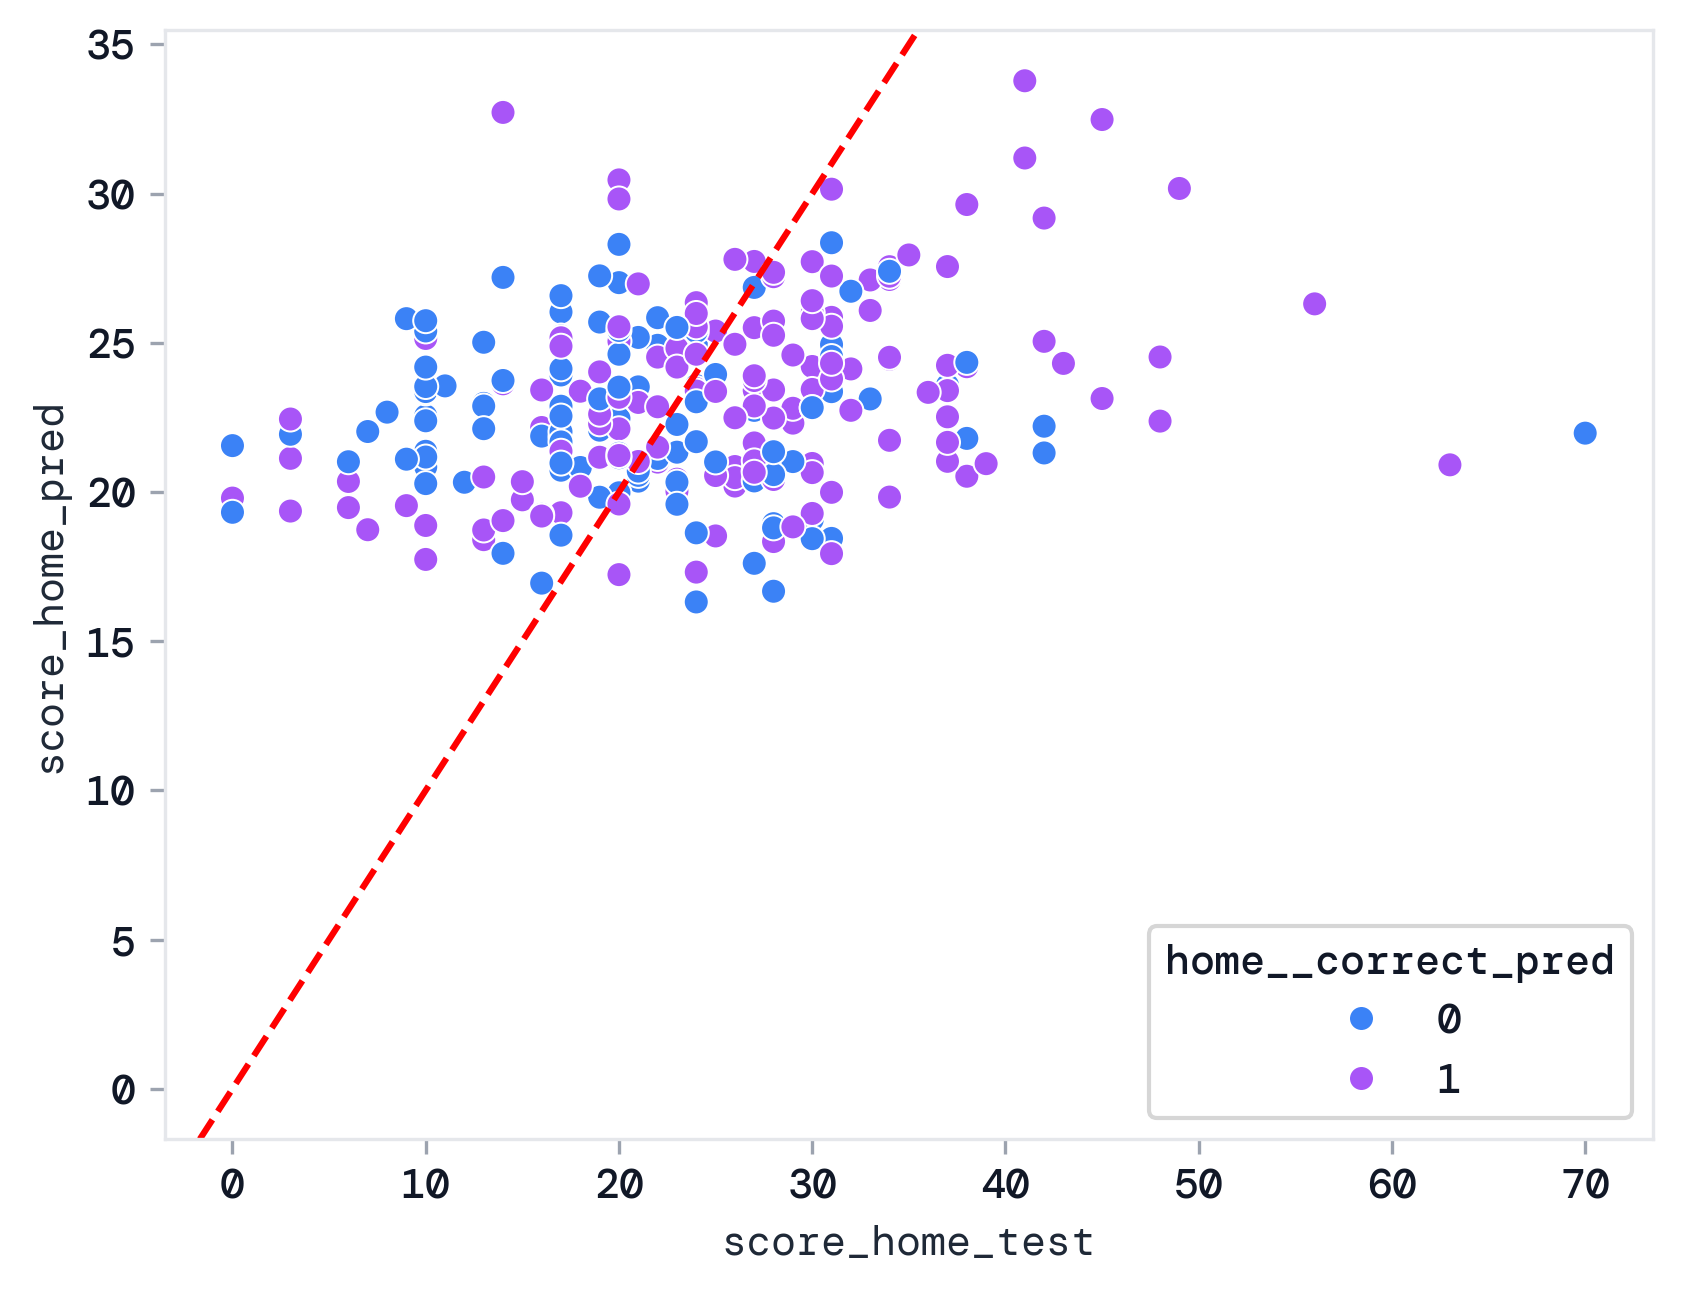

In [17]:
sns.scatterplot(data = rfr_results,
                x = 'score_home_test',
                y = 'score_home_pred',
                hue = 'home__correct_pred')
plt.axline((0, 0), slope=1, color='red', linestyle='--')

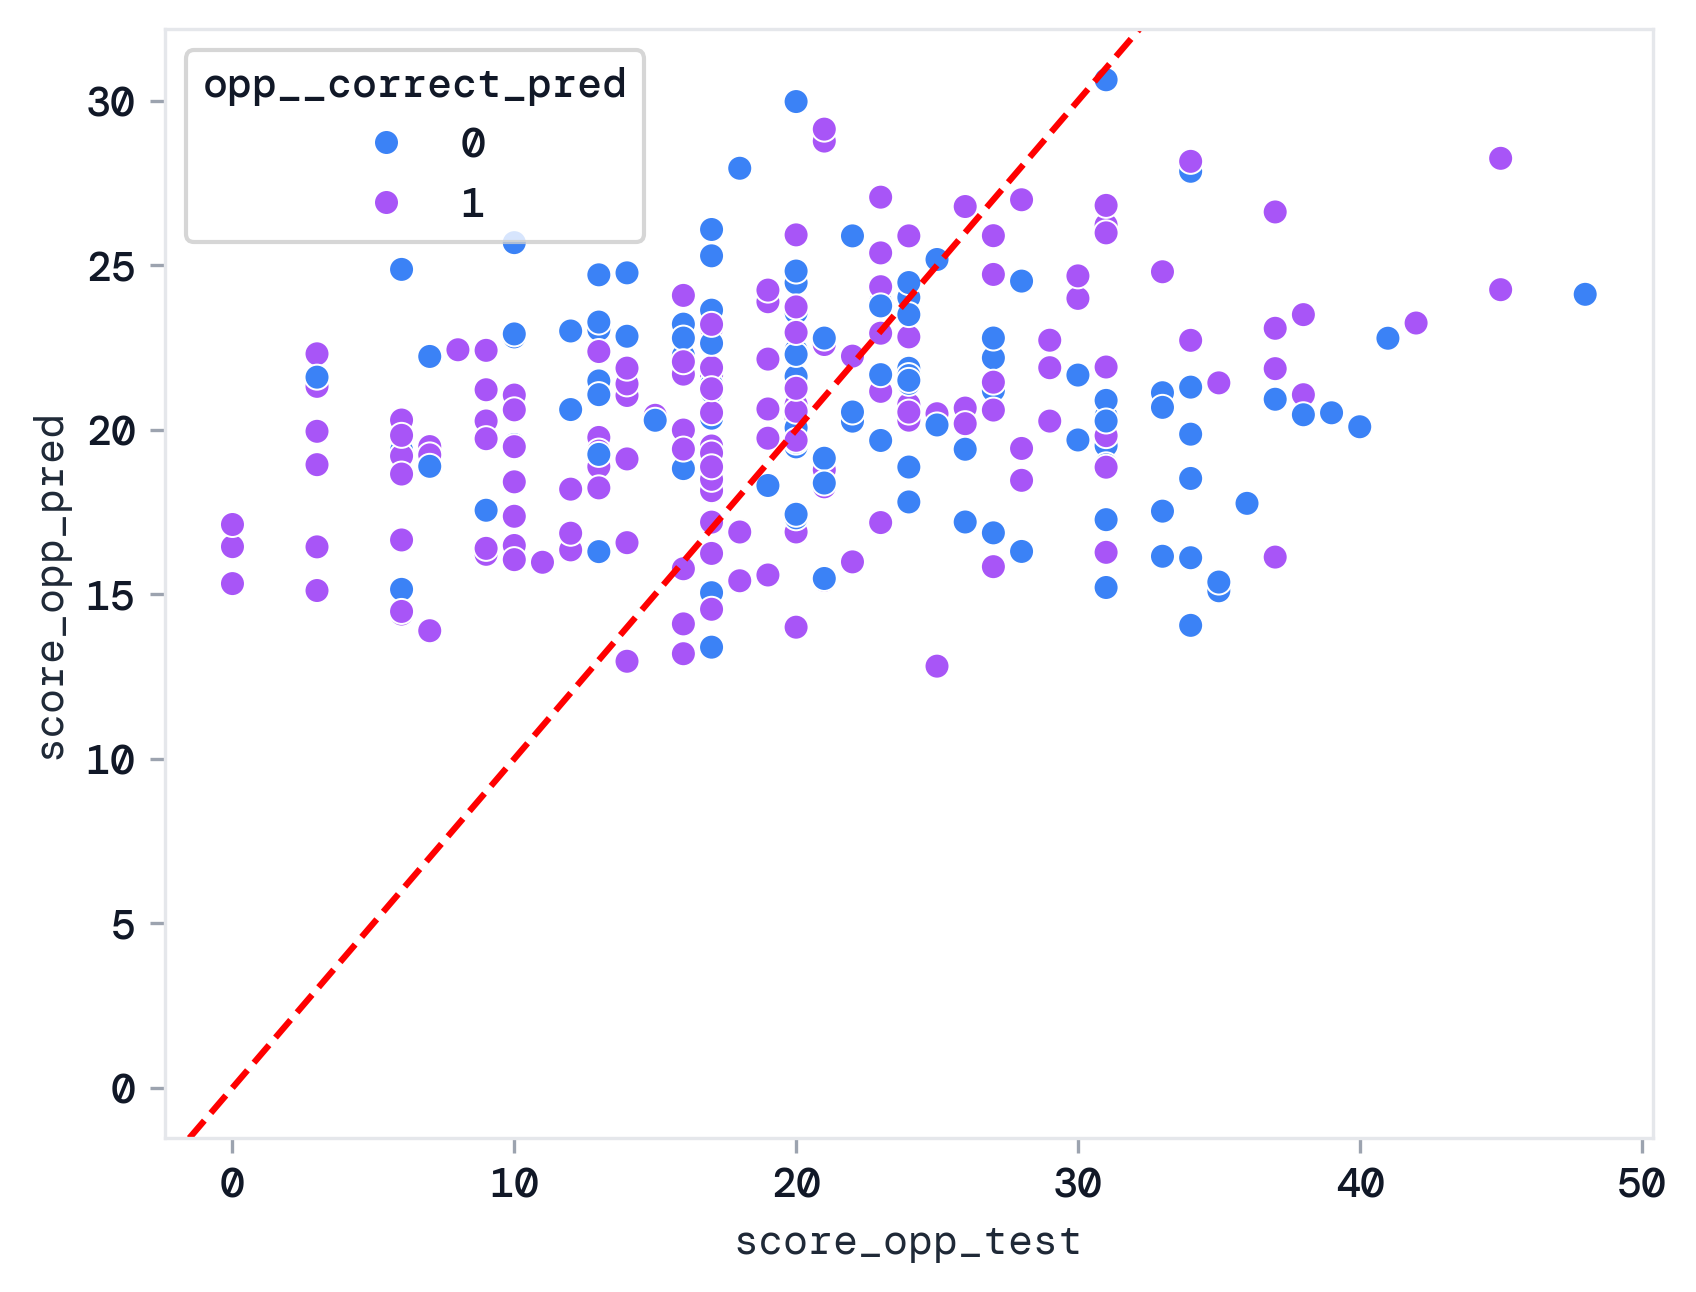

In [18]:
sns.scatterplot(data = rfr_results,
                x = 'score_opp_test',
                y = 'score_opp_pred',
                hue = 'opp__correct_pred')
plt.axline((0, 0), slope=1, color='red', linestyle='--')

In [19]:
# Let's generate a few different statistics for the game:

# Home and Opp Team mape
home_team_non_zero_mape = rfr_results.loc[rfr_results['score_home_test'] > 0, 'home__game_mape'].mean()
opp_team_non_zero_mape = rfr_results.loc[rfr_results['score_opp_test'] > 0, 'opp__game_mape'].mean()

home_zero, opp_zero = sum(rfr_results['score_home_test'] == 0), sum(rfr_results['score_opp_test'] == 0)

print(f"Predicting the home team's score yields a MAPE of {home_team_non_zero_mape*100:.1f}%")
print(f"Predicting the home team's score yields a MAPE of {opp_team_non_zero_mape*100:.1f}%")
print(f"Times the team scored 0 points: {home_zero}.")
print(f"Times the opponent scored 0 points: {opp_zero}.")

Predicting the home team's score yields a MAPE of 47.7%
Predicting the home team's score yields a MAPE of 56.9%
Times the team scored 0 points: 4.
Times the opponent scored 0 points: 3.


<Axes: xlabel='value', ylabel='Count'>

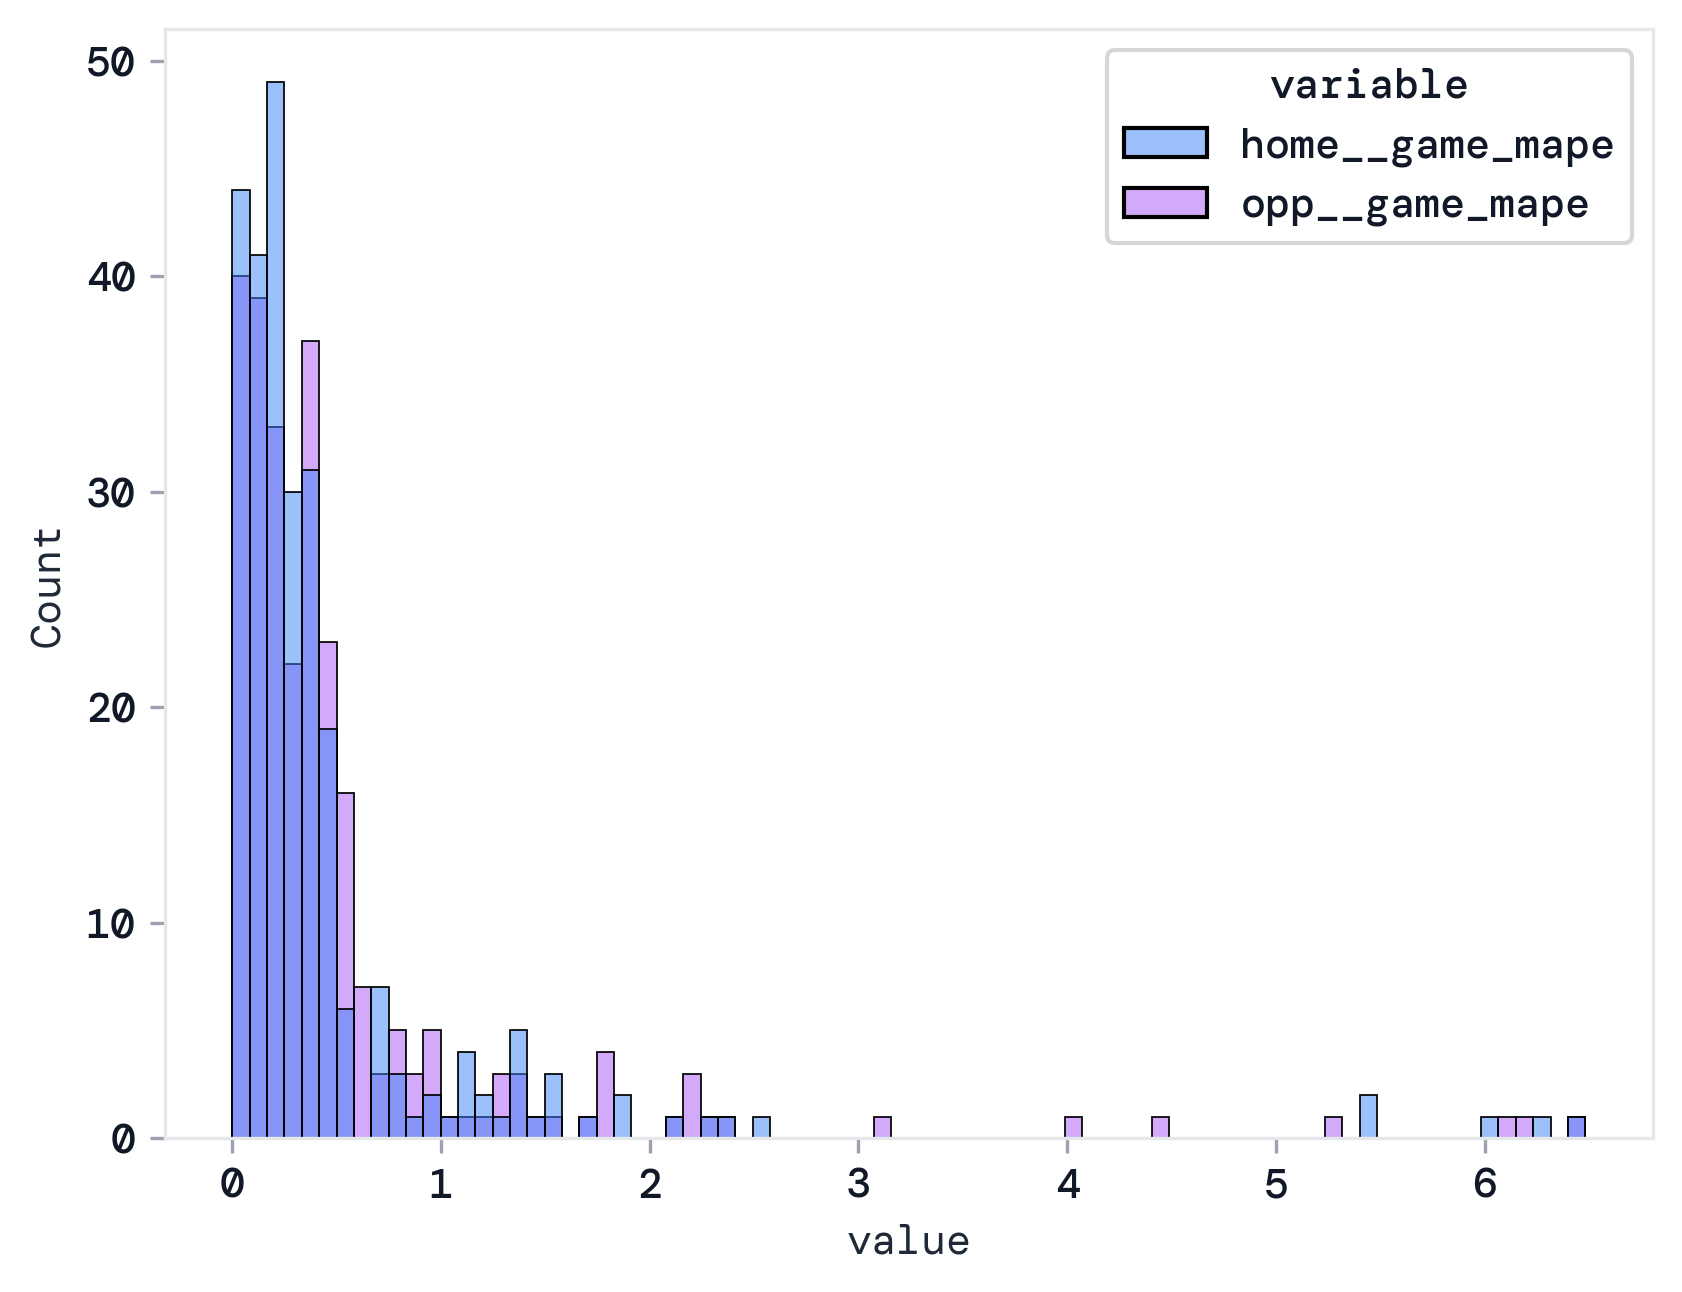

In [53]:
rfr_non_zero = rfr_results.loc[(
    rfr_results['score_home_test'] != 0
) & (
    rfr_results['score_opp_test'] != 0
    )]

rfr_mape = rfr_non_zero[['home__game_mape', 'opp__game_mape']].melt()
sns.histplot(rfr_mape, x = 'value', hue='variable')

In [55]:
rfr_results['home__correct_pred'].sum()/len(rfr_results)

np.float64(0.5687732342007435)

In [21]:
game_df = pd.read_csv('data/intermediate/games_df.csv')
game_df['score_team']


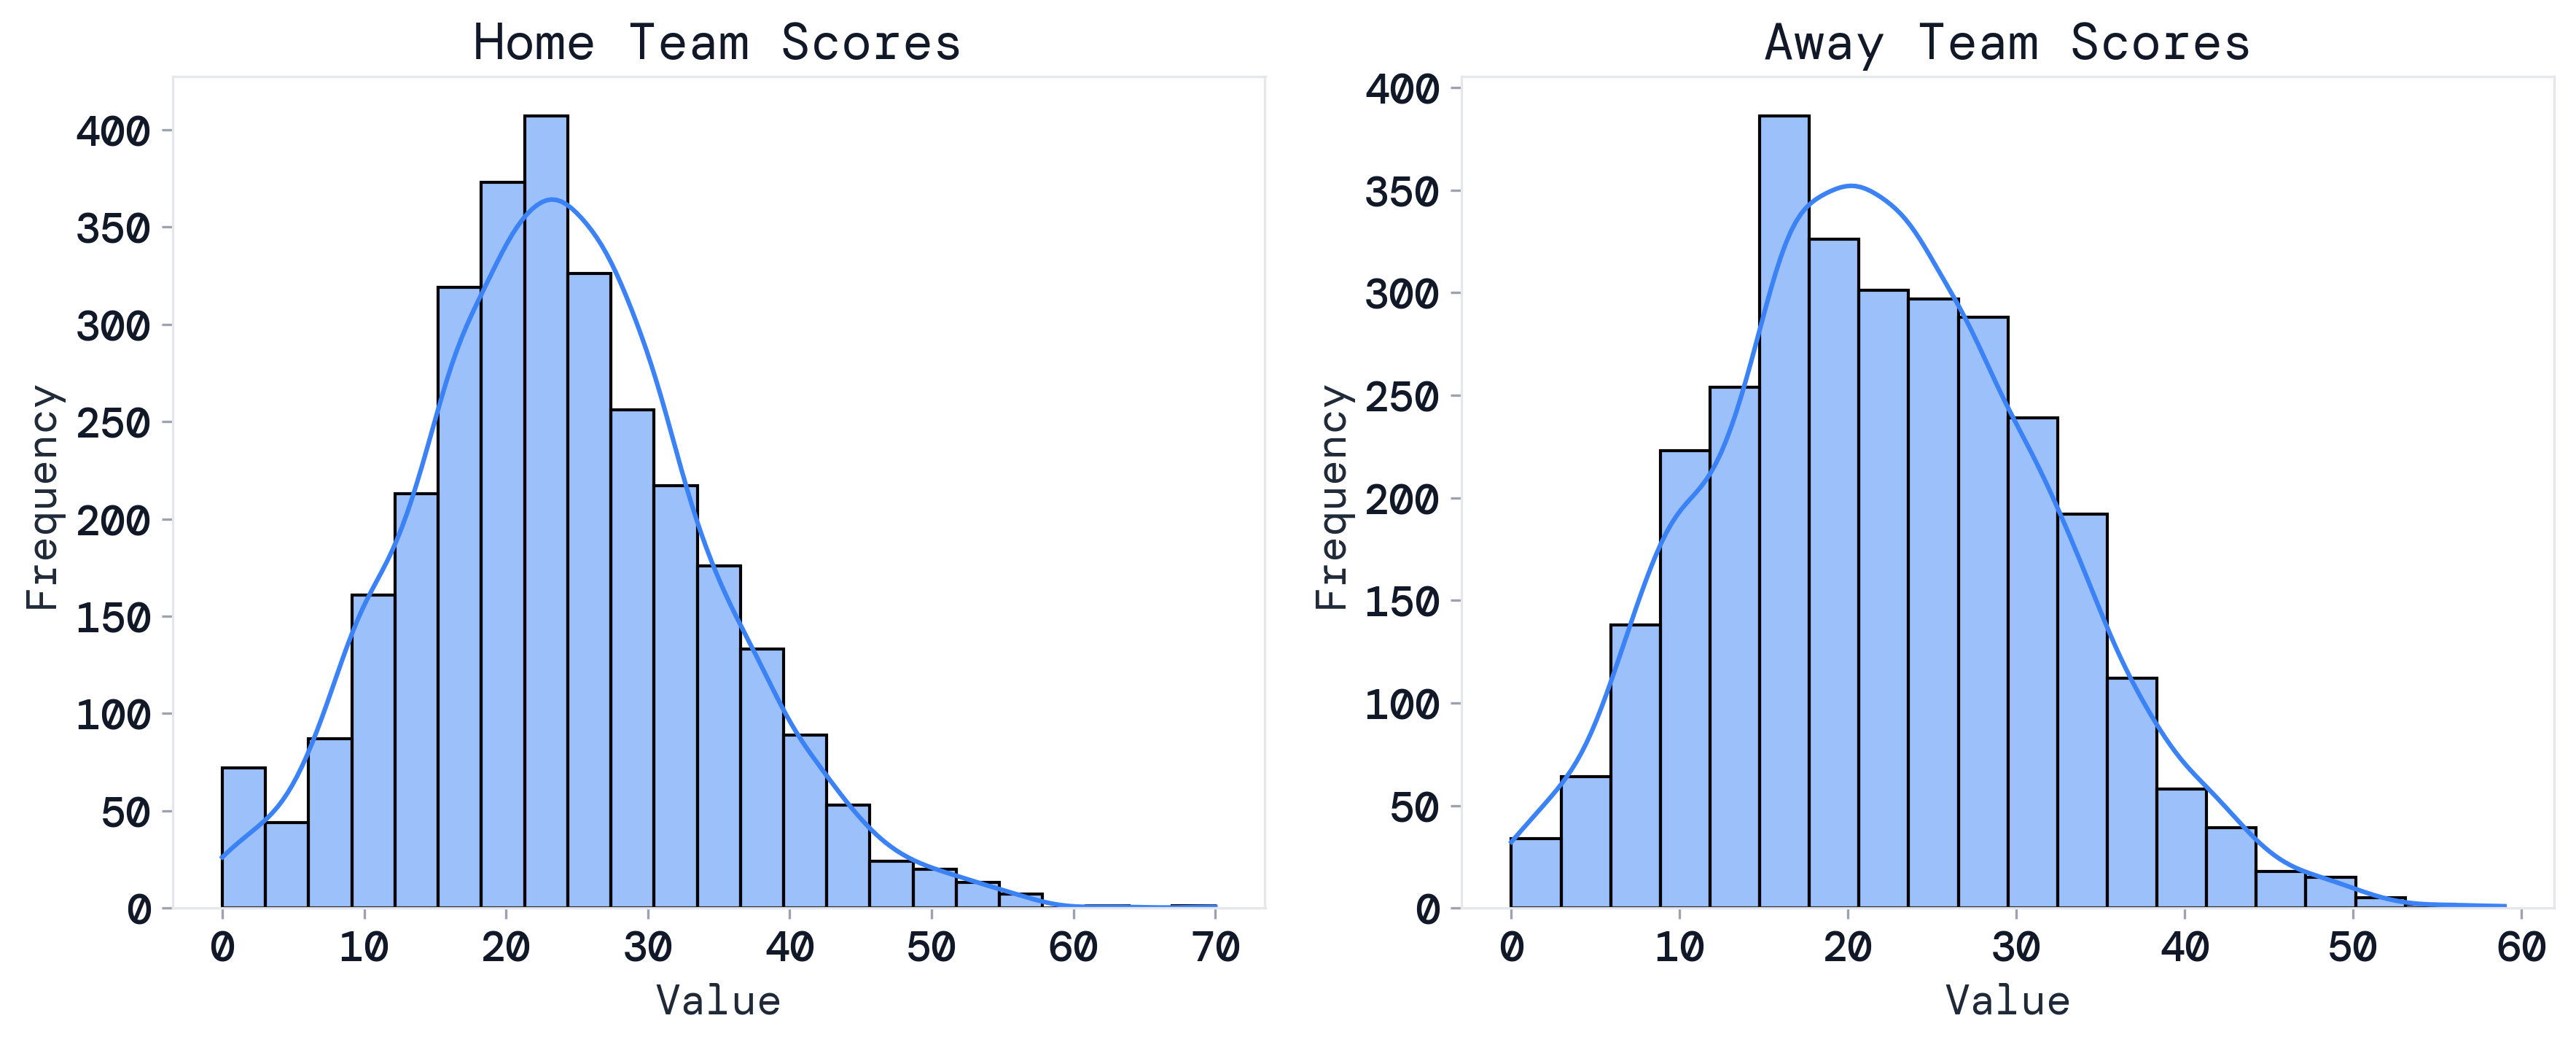

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.rcParams['font.size'] = 14
# Plot the first histogram
sns.histplot(game_df, x='score_team', binwidth=3, ax=axes[0], kde=True)
axes[0].set_title('Home Team Scores')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot the second histogram
sns.histplot(game_df, x='score_opp', binwidth=3, ax=axes[1], kde=True)
axes[1].set_title('Away Team Scores')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()